## S3 Access for cloud enabled datasets

If a given dataset is in the cloud we have a set of libraries to access them. If the data is in a cloud friendly format we can efficiently load only what we need. If not we may need to read entire files.

Dependencies:

* [Valid `.netrc`](https://github.com/NASA-Openscapes/2021-Cloud-Hackathon/blob/main/tutorials/04_NASA_Earthdata_Authentication.ipynb) file in home directory
* Running this code in AWS **us-west-2** (Like we are in the Openscapes hub)

Glossary

* Collection:
* Granule:
* S3: 
* S3 bucket:

In [1]:
import requests
from pprint import pprint
from pathlib import Path
import s3fs
import fsspec

import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
# setting the endpoints and credentials

# This endpoint is specific to PODAAC, if we want cloud data from a different DAAC
# we need to change it. See: https://raw.githubusercontent.com/betolink/earthdata/main/earthdata/daac.py 
s3_cred_endpoint = 'https://archive.podaac.earthdata.nasa.gov/s3credentials'

cmr_search_url = 'https://cmr.earthdata.nasa.gov/search'
cmr_collection_url = f'{cmr_search_url}/{"collections"}'

cmr_search_url = 'https://cmr.earthdata.nasa.gov/search'
cmr_collection_url = f'{cmr_search_url}/{"collections"}'


def get_temp_creds():
    temp_creds_url = s3_cred_endpoint
    return requests.get(temp_creds_url).json()
temp_creds_req = get_temp_creds()

s3_fs = s3fs.S3FileSystem(
    key=temp_creds_req['accessKeyId'],
    secret=temp_creds_req['secretAccessKey'],
    token=temp_creds_req['sessionToken'],
    client_kwargs={'region_name':'us-west-2'},
)

In [3]:
# Search parameters

# In this case we know the dataset id in advance but we could use CMR to look for one
data_name = 'AVHRR_OI-NCEI-L4-GLOB-v2.1'
# Bounding Box spatial parameter in decimal degree 'W,S,E,N' format.
# If the dataset is global the bbox is just ignored because it will match anything.
bounding_box = '-105,21,-125,32'
# Each date in yyyy-MM-ddTHH:mm:ssZ format; date range in start,end format
temporal = '2019-06-22T00:00:00Z,2019-06-23T23:59:59Z'

In [4]:
response = requests.get(cmr_collection_url, 
                        params={
                            'short_name': data_name,
                            'cloud_hosted': 'True',
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
response = response.json()
collections = response['feed']['entry']

for collection in collections:
    print(f'{collection["id"]} {"version:"}{collection["version_id"]}')

data_concept_id = collections[0]["id"]

granule_url = f'{cmr_search_url}/{"granules"}'
response = requests.get(granule_url, 
                        params={
                            'concept_id': data_concept_id,
                            'temporal': temporal,
                            'bounding_box': bounding_box,
                            'page_size': 200,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )

# These are the metadata records for each granule, this is where we get our links to the data
# If the data is in the cloud the link prefix will start with s3://
granules = response.json()['feed']['entry']
urls = []

for granule in granules:
    print(granule['boxes'], granule['links'][0]['href'])
    urls.append(granule['links'][0]['href'])

C2036881712-POCLOUD version:2.1
['-89.875 -179.875 89.875 179.875'] s3://podaac-ops-cumulus-protected/AVHRR_OI-NCEI-L4-GLOB-v2.1/20190621120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc
['-89.875 -179.875 89.875 179.875'] s3://podaac-ops-cumulus-protected/AVHRR_OI-NCEI-L4-GLOB-v2.1/20190622120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc
['-89.875 -179.875 89.875 179.875'] s3://podaac-ops-cumulus-protected/AVHRR_OI-NCEI-L4-GLOB-v2.1/20190623120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc


In [6]:
# If a bucket is listable we can inspect whole directories
# The list of operations for s3fs is in here https://s3fs.readthedocs.io/en/latest/api.html
try:
    bucket = 's3://podaac-ops-cumulus-protected/AVHRR_OI-NCEI-L4-GLOB-v2.1/'
    list = s3_fs.ls(bucket)
    # Let's print the first 5 items
    for item in list[0:5]:
        print(item)
except Exception as e:
    print(e)

podaac-ops-cumulus-protected/AVHRR_OI-NCEI-L4-GLOB-v2.1/20160101120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc
podaac-ops-cumulus-protected/AVHRR_OI-NCEI-L4-GLOB-v2.1/20160101120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc.dmrpp
podaac-ops-cumulus-protected/AVHRR_OI-NCEI-L4-GLOB-v2.1/20160102120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc
podaac-ops-cumulus-protected/AVHRR_OI-NCEI-L4-GLOB-v2.1/20160102120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc.dmrpp
podaac-ops-cumulus-protected/AVHRR_OI-NCEI-L4-GLOB-v2.1/20160103120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc


In [7]:
# Getting data from 1 granule (file) on S3
%time
file = s3_fs.open(urls[0])
ds = xr.open_dataset(file)
ds

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


<xarray.Dataset>
Dimensions:           (lat: 720, lon: 1440, time: 1, nv: 2)
Coordinates:
  * lat               (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon               (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time              (time) datetime64[ns] 2019-06-21
Dimensions without coordinates: nv
Data variables:
    lat_bnds          (lat, nv) float32 ...
    lon_bnds          (lon, nv) float32 ...
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.6, ACDD-1.3
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    id:                         NCEI-L4LRblend-GLOB-AVHRR_OI
    references:                 Reynolds, et al.(2009) What is New in Version...
    institution:                NOAA/NESDIS/NCEI
    creator_name:               NCEI Products and Services
    ...                         ...
    Metadata_Link.:             http://doi.org/10.7289/V5SQ8XB5
    keywords:                   Oceans>Ocean Temperature>Sea Surface Temperature
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   CF Standard Name Table v29
    processing_level:           L4
    cdm_data_type:              Grid

In [8]:
# If we are opening multiple files that are on the same projection we can stack them
%time
fileset = [s3_fs.open(file) for file in urls] 
ds_stacked = xr.open_mfdataset(fileset, combine='by_coords')
ds_stacked

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


<xarray.Dataset>
Dimensions:           (lat: 720, lon: 1440, time: 3, nv: 2)
Coordinates:
  * lat               (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon               (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time              (time) datetime64[ns] 2019-06-21 2019-06-22 2019-06-23
Dimensions without coordinates: nv
Data variables:
    lat_bnds          (time, lat, nv) float32 dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bnds          (time, lon, nv) float32 dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.6, ACDD-1.3
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    id:                         NCEI-L4LRblend-GLOB-AVHRR_OI
    references:                 Reynolds, et al.(2009) What is New in Version...
    institution:                NOAA/NESDIS/NCEI
    creator_name:               NCEI Products and Services
    ...                         ...
    Metadata_Link.:             http://doi.org/10.7289/V5SQ8XB5
    keywords:                   Oceans>Ocean Temperature>Sea Surface Temperature
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   CF Standard Name Table v29
    processing_level:           L4
    cdm_data_type:              Grid

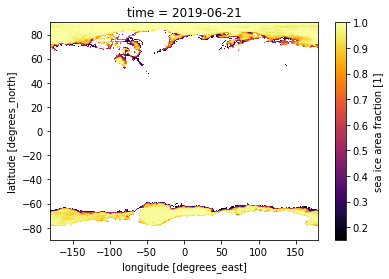

In [9]:
ds_stacked.sea_ice_fraction.sel(time='2019-06-21').plot(cmap="inferno")

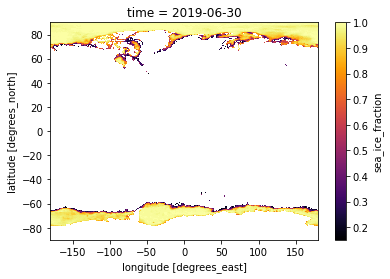

In [10]:
# simple monthly mean (with only 3 days) for a given variable
ds_stacked.sea_ice_fraction.resample(time='M').mean().plot(cmap="inferno")